# Part 3.3

Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biL-STM model and a biGRU model, incorporating recurrent computations in both directions and stacking multiple layers if possible

Comparison between the models : 
+ (+)RNNs process data in a sequential manner (one direction); they retain information from previous steps but can struggle to remember distant information due to issues like vanishing gradients.
- (-)RNNs fail to capture long-term dependencies, especially in long sequences, as the information fades over time, and gradients vanish during backpropagation through time. Limits effectiveness in tasks requiring model to remember information over many time steps.
-----------------------------------------------
- (+)BiLSTM : Bidirectional Long Short-Term Memory, a RNN, handle long term dependencies better. It has gates that help regulate flow of information, enabling them to retain or discard information as needed.

- BiLSTM consists of 2 LSTM layers running in opposite directions : 1 processes sequence from past to future, while other processes it from future to past : captures both past and future context for each time step 

- BiLSTM helps to capture context from both directions, beneficial in tasks where understanding context of each word is important

- (-) BiLSTMs are computationally more intensive than regular LSTMs and RNNs due to bidirectional component and complexity of gating mechanism
-----------------------------------------------
- (+)BiGRU, type of RNN, has 2 gates instead of 3 used by LSTMS - makes GRUs faster to computer while still handling long-term dependencies better than traditional RNNs. Includes 2 GRU layers, one running forward one running backward, learnign both past and present context. 

- BiGRUs achieve similar performance to BiLSTMs but with fewer parameters and faster computation, making them more efficient for large datasets 

- (-)Although GRUs generally simpler and faster, might be less expressive in certain cases due to absence of output gate

In [1]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from utils.utils import *
from dotenv import load_dotenv
import os

load_dotenv()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data preparation

In [2]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [3]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [4]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

In [5]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [6]:
BATCH_SIZE = 32

In [7]:
trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# biL-STM model

In [8]:
MODEL_TYPE = "lstm"
LR = 0.0001

## Last State LSTM

### 2 layers

In [9]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="last_state"
)

In [10]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state"
)

Epoch   1/100, Loss: 0.6931, Accuracy: 0.5038
Model saved.
Epoch   2/100, Loss: 0.6901, Accuracy: 0.5591
Model saved.
Epoch   3/100, Loss: 0.6741, Accuracy: 0.5638
Model saved.
Epoch   4/100, Loss: 0.6607, Accuracy: 0.5713
Model saved.
Epoch   5/100, Loss: 0.6449, Accuracy: 0.5863
Model saved.
Epoch   6/100, Loss: 0.6261, Accuracy: 0.5957
Model saved.
Epoch   7/100, Loss: 0.6135, Accuracy: 0.5910
Epoch   8/100, Loss: 0.6004, Accuracy: 0.5947
Epoch   9/100, Loss: 0.5893, Accuracy: 0.5854
Epoch  10/100, Loss: 0.5785, Accuracy: 0.6051
Model saved.
Epoch  11/100, Loss: 0.5651, Accuracy: 0.5807
Epoch  12/100, Loss: 0.5567, Accuracy: 0.5910
Epoch  13/100, Loss: 0.5472, Accuracy: 0.5947
Epoch  14/100, Loss: 0.5283, Accuracy: 0.6069
Model saved.
Epoch  15/100, Loss: 0.5134, Accuracy: 0.6013
Epoch  16/100, Loss: 0.4928, Accuracy: 0.6107
Model saved.
Epoch  17/100, Loss: 0.4749, Accuracy: 0.6201
Model saved.
Epoch  18/100, Loss: 0.4568, Accuracy: 0.6201
Epoch  19/100, Loss: 0.4400, Accuracy: 0.6

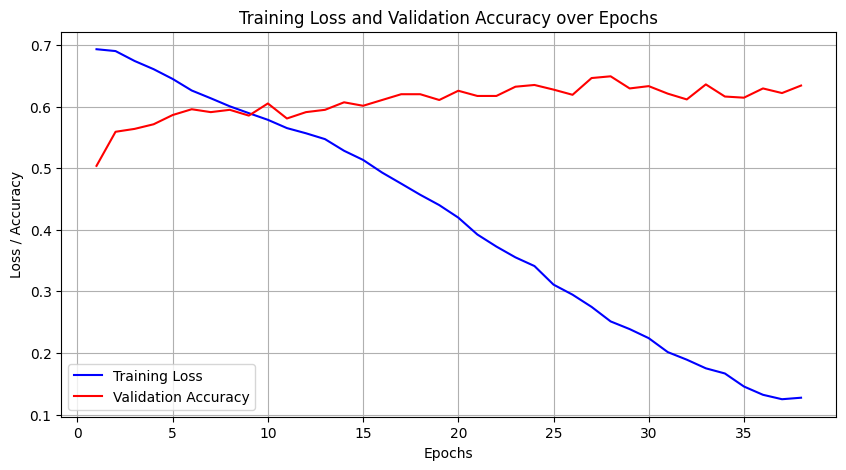

In [11]:
plot_loss_accuracy(losses, accuracies)

In [12]:
last_lstm_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6595


### 4 layers

Trying with an increased number of stack layers

In [13]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # increased to 4 for stacking multiple layers
    pooling_method="last_state"
)

In [14]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state"
)

Epoch   1/100, Loss: 0.6932, Accuracy: 0.4897
Model saved.
Epoch   2/100, Loss: 0.6847, Accuracy: 0.5600
Model saved.
Epoch   3/100, Loss: 0.6624, Accuracy: 0.5750
Model saved.
Epoch   4/100, Loss: 0.6451, Accuracy: 0.5882
Model saved.
Epoch   5/100, Loss: 0.6272, Accuracy: 0.5882
Epoch   6/100, Loss: 0.6149, Accuracy: 0.5882
Epoch   7/100, Loss: 0.6056, Accuracy: 0.5891
Model saved.
Epoch   8/100, Loss: 0.5952, Accuracy: 0.5901
Model saved.
Epoch   9/100, Loss: 0.5828, Accuracy: 0.5994
Model saved.
Epoch  10/100, Loss: 0.5707, Accuracy: 0.5985
Epoch  11/100, Loss: 0.5647, Accuracy: 0.5910
Epoch  12/100, Loss: 0.5478, Accuracy: 0.6098
Model saved.
Epoch  13/100, Loss: 0.5373, Accuracy: 0.6154
Model saved.
Epoch  14/100, Loss: 0.5235, Accuracy: 0.6098
Epoch  15/100, Loss: 0.4947, Accuracy: 0.6107
Epoch  16/100, Loss: 0.4759, Accuracy: 0.6257
Model saved.
Epoch  17/100, Loss: 0.4605, Accuracy: 0.6276
Model saved.
Epoch  18/100, Loss: 0.4401, Accuracy: 0.6285
Model saved.
Epoch  19/100, L

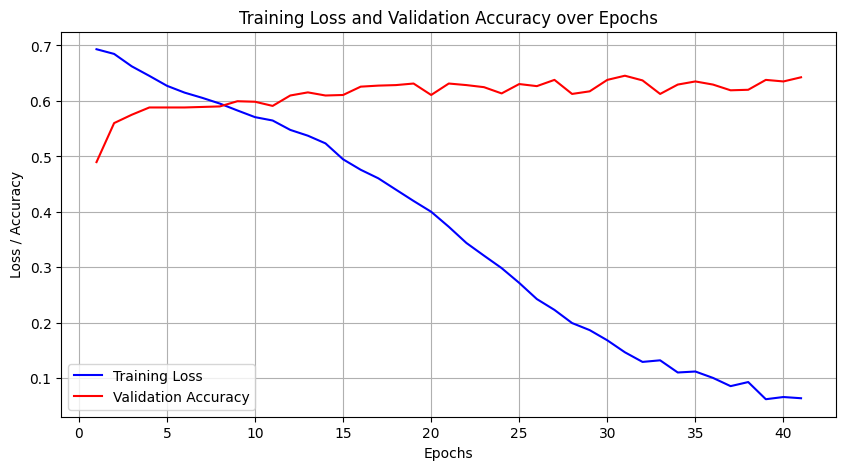

In [15]:
plot_loss_accuracy(losses, accuracies)

In [16]:
last_lstm_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6538


## Mean Pool

### 2 layers


In [17]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="mean_pool"
)

In [18]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_pool"
)

Epoch   1/100, Loss: 0.6927, Accuracy: 0.5094
Model saved.
Epoch   2/100, Loss: 0.6806, Accuracy: 0.5694
Model saved.
Epoch   3/100, Loss: 0.6573, Accuracy: 0.5947
Model saved.
Epoch   4/100, Loss: 0.6411, Accuracy: 0.5994
Model saved.
Epoch   5/100, Loss: 0.6278, Accuracy: 0.5976
Epoch   6/100, Loss: 0.6196, Accuracy: 0.6032
Model saved.
Epoch   7/100, Loss: 0.6076, Accuracy: 0.6079
Model saved.
Epoch   8/100, Loss: 0.5973, Accuracy: 0.6051
Epoch   9/100, Loss: 0.5913, Accuracy: 0.5994
Epoch  10/100, Loss: 0.5781, Accuracy: 0.6201
Model saved.
Epoch  11/100, Loss: 0.5699, Accuracy: 0.6135
Epoch  12/100, Loss: 0.5579, Accuracy: 0.6295
Model saved.
Epoch  13/100, Loss: 0.5425, Accuracy: 0.6229
Epoch  14/100, Loss: 0.5265, Accuracy: 0.6295
Epoch  15/100, Loss: 0.5091, Accuracy: 0.5985
Epoch  16/100, Loss: 0.4974, Accuracy: 0.6257
Epoch  17/100, Loss: 0.4806, Accuracy: 0.6332
Model saved.
Epoch  18/100, Loss: 0.4583, Accuracy: 0.6220
Epoch  19/100, Loss: 0.4483, Accuracy: 0.6398
Model sav

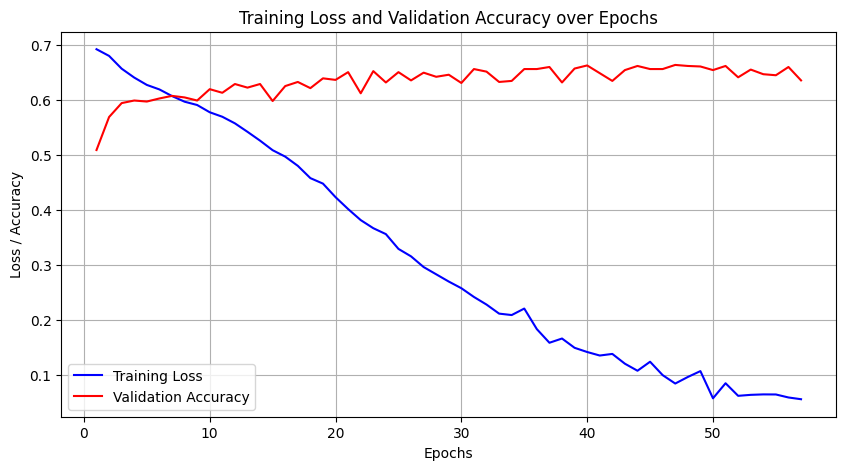

In [19]:
plot_loss_accuracy(losses, accuracies)

In [20]:
mean_lstm_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6426


### 4 layers


In [21]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # increased to 4 for stacking multiple layers
    pooling_method="mean_pool"
)

In [22]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_pool"
)

Epoch   1/100, Loss: 0.6932, Accuracy: 0.5225
Model saved.
Epoch   2/100, Loss: 0.6795, Accuracy: 0.5675
Model saved.
Epoch   3/100, Loss: 0.6577, Accuracy: 0.5910
Model saved.
Epoch   4/100, Loss: 0.6413, Accuracy: 0.5929
Model saved.
Epoch   5/100, Loss: 0.6257, Accuracy: 0.6013
Model saved.
Epoch   6/100, Loss: 0.6154, Accuracy: 0.6023
Model saved.
Epoch   7/100, Loss: 0.6061, Accuracy: 0.6069
Model saved.
Epoch   8/100, Loss: 0.5953, Accuracy: 0.5938
Epoch   9/100, Loss: 0.5844, Accuracy: 0.5957
Epoch  10/100, Loss: 0.5728, Accuracy: 0.6088
Model saved.
Epoch  11/100, Loss: 0.5600, Accuracy: 0.6004
Epoch  12/100, Loss: 0.5446, Accuracy: 0.6304
Model saved.
Epoch  13/100, Loss: 0.5325, Accuracy: 0.6173
Epoch  14/100, Loss: 0.5135, Accuracy: 0.6107
Epoch  15/100, Loss: 0.4980, Accuracy: 0.6492
Model saved.
Epoch  16/100, Loss: 0.4844, Accuracy: 0.6032
Epoch  17/100, Loss: 0.4612, Accuracy: 0.6426
Epoch  18/100, Loss: 0.4433, Accuracy: 0.6341
Epoch  19/100, Loss: 0.4198, Accuracy: 0.6

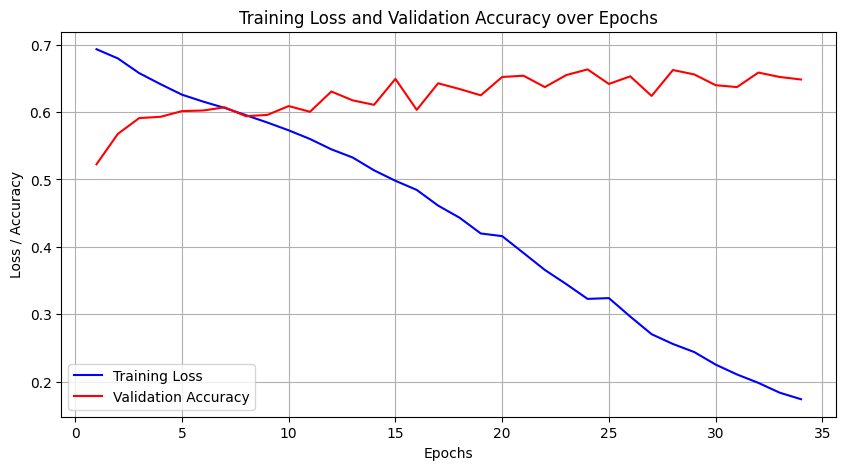

In [23]:
plot_loss_accuracy(losses, accuracies)

In [24]:
mean_lstm_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6689


## Max Pooling


### 2 layers

In [25]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="max_pool"
)

In [26]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool"
)

Epoch   1/100, Loss: 0.6928, Accuracy: 0.5075
Model saved.
Epoch   2/100, Loss: 0.6837, Accuracy: 0.5563
Model saved.
Epoch   3/100, Loss: 0.6657, Accuracy: 0.5947
Model saved.
Epoch   4/100, Loss: 0.6436, Accuracy: 0.5976
Model saved.
Epoch   5/100, Loss: 0.6282, Accuracy: 0.5919
Epoch   6/100, Loss: 0.6185, Accuracy: 0.5994
Model saved.
Epoch   7/100, Loss: 0.6066, Accuracy: 0.6032
Model saved.
Epoch   8/100, Loss: 0.5953, Accuracy: 0.5901
Epoch   9/100, Loss: 0.5863, Accuracy: 0.5966
Epoch  10/100, Loss: 0.5764, Accuracy: 0.6013
Epoch  11/100, Loss: 0.5664, Accuracy: 0.5976
Epoch  12/100, Loss: 0.5542, Accuracy: 0.6060
Model saved.
Epoch  13/100, Loss: 0.5384, Accuracy: 0.6116
Model saved.
Epoch  14/100, Loss: 0.5241, Accuracy: 0.6313
Model saved.
Epoch  15/100, Loss: 0.5099, Accuracy: 0.6341
Model saved.
Epoch  16/100, Loss: 0.4907, Accuracy: 0.6257
Epoch  17/100, Loss: 0.4724, Accuracy: 0.6323
Epoch  18/100, Loss: 0.4618, Accuracy: 0.6313
Epoch  19/100, Loss: 0.4370, Accuracy: 0.6

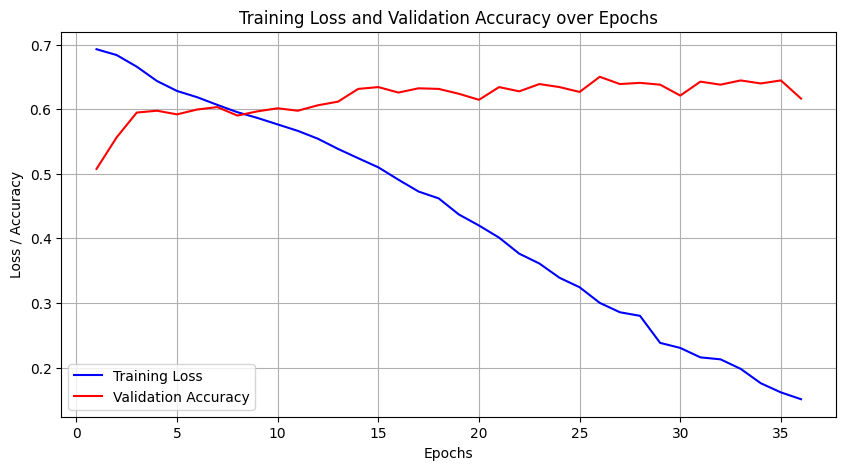

In [27]:
plot_loss_accuracy(losses, accuracies)

In [28]:
max_lstm_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6585


### 4 layers

In [29]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # set to 4 for stacking multiple layers
    pooling_method="max_pool"
)

In [30]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool"
)

Epoch   1/100, Loss: 0.6934, Accuracy: 0.5516
Model saved.
Epoch   2/100, Loss: 0.6842, Accuracy: 0.5647
Model saved.
Epoch   3/100, Loss: 0.6592, Accuracy: 0.5863
Model saved.
Epoch   4/100, Loss: 0.6402, Accuracy: 0.6060
Model saved.
Epoch   5/100, Loss: 0.6288, Accuracy: 0.6060
Epoch   6/100, Loss: 0.6124, Accuracy: 0.5994
Epoch   7/100, Loss: 0.6038, Accuracy: 0.5919
Epoch   8/100, Loss: 0.5950, Accuracy: 0.6079
Model saved.
Epoch   9/100, Loss: 0.5825, Accuracy: 0.5957
Epoch  10/100, Loss: 0.5727, Accuracy: 0.6201
Model saved.
Epoch  11/100, Loss: 0.5568, Accuracy: 0.6313
Model saved.
Epoch  12/100, Loss: 0.5483, Accuracy: 0.6220
Epoch  13/100, Loss: 0.5301, Accuracy: 0.6295
Epoch  14/100, Loss: 0.5208, Accuracy: 0.6210
Epoch  15/100, Loss: 0.5006, Accuracy: 0.6229
Epoch  16/100, Loss: 0.4866, Accuracy: 0.6398
Model saved.
Epoch  17/100, Loss: 0.4749, Accuracy: 0.6126
Epoch  18/100, Loss: 0.4488, Accuracy: 0.6257
Epoch  19/100, Loss: 0.4384, Accuracy: 0.6173
Epoch  20/100, Loss: 0

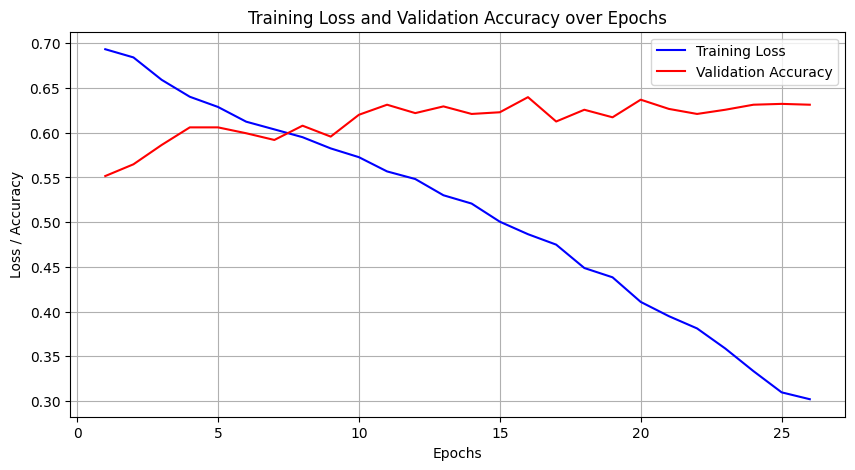

In [31]:
plot_loss_accuracy(losses, accuracies)

In [32]:
max_lstm_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6651


## Mean Max Pooling


### 2 layers

In [33]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="mean_max"
)

In [34]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6929, Accuracy: 0.5094
Model saved.
Epoch   2/100, Loss: 0.6812, Accuracy: 0.5891
Model saved.
Epoch   3/100, Loss: 0.6590, Accuracy: 0.5901
Model saved.
Epoch   4/100, Loss: 0.6431, Accuracy: 0.5976
Model saved.
Epoch   5/100, Loss: 0.6258, Accuracy: 0.6051
Model saved.
Epoch   6/100, Loss: 0.6183, Accuracy: 0.5901
Epoch   7/100, Loss: 0.6062, Accuracy: 0.5994
Epoch   8/100, Loss: 0.5973, Accuracy: 0.6079
Model saved.
Epoch   9/100, Loss: 0.5873, Accuracy: 0.6107
Model saved.
Epoch  10/100, Loss: 0.5773, Accuracy: 0.6069
Epoch  11/100, Loss: 0.5677, Accuracy: 0.6069
Epoch  12/100, Loss: 0.5549, Accuracy: 0.6182
Model saved.
Epoch  13/100, Loss: 0.5423, Accuracy: 0.6144
Epoch  14/100, Loss: 0.5259, Accuracy: 0.6210
Model saved.
Epoch  15/100, Loss: 0.5109, Accuracy: 0.6060
Epoch  16/100, Loss: 0.4982, Accuracy: 0.6248
Model saved.
Epoch  17/100, Loss: 0.4803, Accuracy: 0.6379
Model saved.
Epoch  18/100, Loss: 0.4650, Accuracy: 0.6238
Epoch  19/100, Loss: 0.4461, 

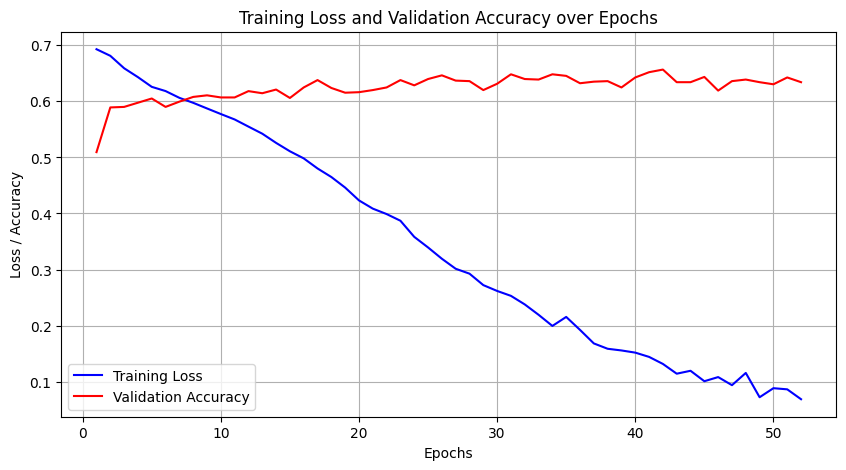

In [35]:
plot_loss_accuracy(losses, accuracies)

In [36]:
mean_max_lstm_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6707


### 4 layers

In [37]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # set to 4 for stacking multiple layers
    pooling_method="mean_max"
)

In [38]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6932, Accuracy: 0.5469
Model saved.
Epoch   2/100, Loss: 0.6799, Accuracy: 0.5572
Model saved.
Epoch   3/100, Loss: 0.6601, Accuracy: 0.6107
Model saved.
Epoch   4/100, Loss: 0.6432, Accuracy: 0.6116
Model saved.
Epoch   5/100, Loss: 0.6296, Accuracy: 0.5929
Epoch   6/100, Loss: 0.6186, Accuracy: 0.6023
Epoch   7/100, Loss: 0.6119, Accuracy: 0.6088
Epoch   8/100, Loss: 0.5972, Accuracy: 0.6004
Epoch   9/100, Loss: 0.5874, Accuracy: 0.6107
Epoch  10/100, Loss: 0.5760, Accuracy: 0.6107
Epoch  11/100, Loss: 0.5642, Accuracy: 0.6041
Epoch  12/100, Loss: 0.5544, Accuracy: 0.6088
Epoch  13/100, Loss: 0.5398, Accuracy: 0.6173
Model saved.
Epoch  14/100, Loss: 0.5276, Accuracy: 0.6220
Model saved.
Epoch  15/100, Loss: 0.5111, Accuracy: 0.6332
Model saved.
Epoch  16/100, Loss: 0.4904, Accuracy: 0.6360
Model saved.
Epoch  17/100, Loss: 0.4803, Accuracy: 0.6445
Model saved.
Epoch  18/100, Loss: 0.4601, Accuracy: 0.6304
Epoch  19/100, Loss: 0.4381, Accuracy: 0.6285
Epoch  20

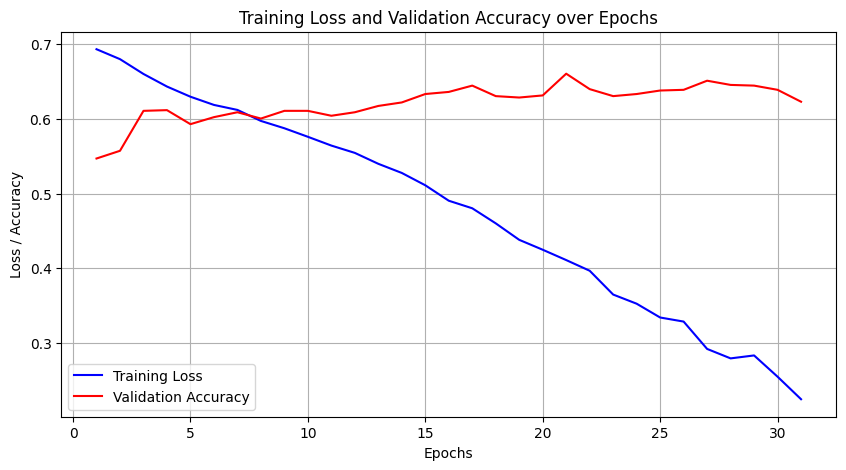

In [39]:
plot_loss_accuracy(losses, accuracies)

In [40]:
mean_max_lstm_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6632


## Attention


### 2 layers

In [41]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="attention"
)

In [42]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6928, Accuracy: 0.5178
Model saved.
Epoch   2/100, Loss: 0.6834, Accuracy: 0.5694
Model saved.
Epoch   3/100, Loss: 0.6569, Accuracy: 0.5938
Model saved.
Epoch   4/100, Loss: 0.6412, Accuracy: 0.5938
Epoch   5/100, Loss: 0.6278, Accuracy: 0.5985
Model saved.
Epoch   6/100, Loss: 0.6175, Accuracy: 0.5985
Epoch   7/100, Loss: 0.6070, Accuracy: 0.5994
Model saved.
Epoch   8/100, Loss: 0.5965, Accuracy: 0.6116
Model saved.
Epoch   9/100, Loss: 0.5881, Accuracy: 0.5788
Epoch  10/100, Loss: 0.5827, Accuracy: 0.6004
Epoch  11/100, Loss: 0.5691, Accuracy: 0.6098
Epoch  12/100, Loss: 0.5562, Accuracy: 0.6163
Model saved.
Epoch  13/100, Loss: 0.5444, Accuracy: 0.6257
Model saved.
Epoch  14/100, Loss: 0.5332, Accuracy: 0.6229
Epoch  15/100, Loss: 0.5195, Accuracy: 0.6201
Epoch  16/100, Loss: 0.5005, Accuracy: 0.6285
Model saved.
Epoch  17/100, Loss: 0.4798, Accuracy: 0.6201
Epoch  18/100, Loss: 0.4611, Accuracy: 0.6398
Model saved.
Epoch  19/100, Loss: 0.4395, Accuracy: 0.6

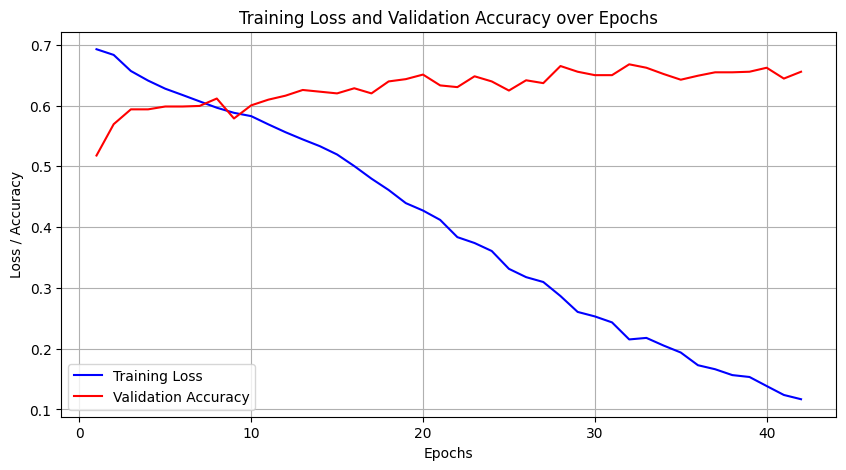

In [43]:
plot_loss_accuracy(losses, accuracies)

In [44]:
attention_lstm_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6689


### 4 layers

In [45]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # set to 4 for stacking multiple layers
    pooling_method="attention"
)

In [46]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6932, Accuracy: 0.5450
Model saved.
Epoch   2/100, Loss: 0.6834, Accuracy: 0.5872
Model saved.
Epoch   3/100, Loss: 0.6650, Accuracy: 0.5769
Epoch   4/100, Loss: 0.6418, Accuracy: 0.6004
Model saved.
Epoch   5/100, Loss: 0.6260, Accuracy: 0.6069
Model saved.
Epoch   6/100, Loss: 0.6135, Accuracy: 0.5863
Epoch   7/100, Loss: 0.6036, Accuracy: 0.5966
Epoch   8/100, Loss: 0.5964, Accuracy: 0.6032
Epoch   9/100, Loss: 0.5856, Accuracy: 0.6116
Model saved.
Epoch  10/100, Loss: 0.5696, Accuracy: 0.5938
Epoch  11/100, Loss: 0.5633, Accuracy: 0.6173
Model saved.
Epoch  12/100, Loss: 0.5492, Accuracy: 0.6229
Model saved.
Epoch  13/100, Loss: 0.5376, Accuracy: 0.6191
Epoch  14/100, Loss: 0.5245, Accuracy: 0.6144
Epoch  15/100, Loss: 0.5041, Accuracy: 0.6360
Model saved.
Epoch  16/100, Loss: 0.4883, Accuracy: 0.6201
Epoch  17/100, Loss: 0.4695, Accuracy: 0.6229
Epoch  18/100, Loss: 0.4545, Accuracy: 0.6220
Epoch  19/100, Loss: 0.4360, Accuracy: 0.6229
Epoch  20/100, Loss: 0

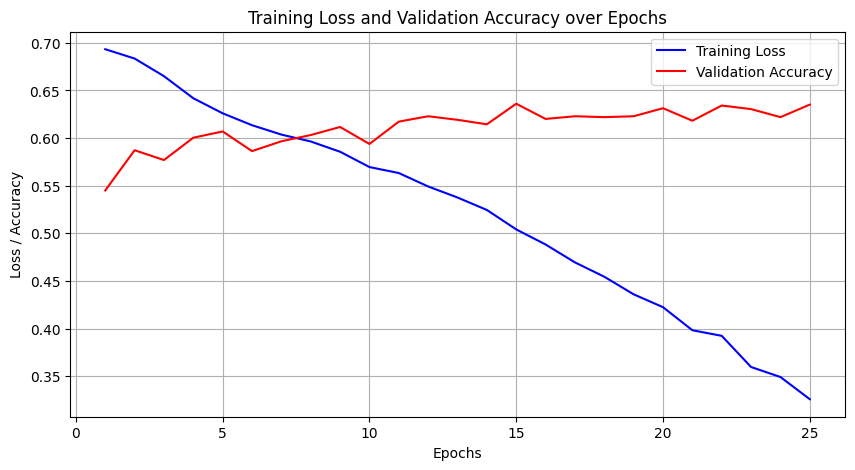

In [47]:
plot_loss_accuracy(losses, accuracies)

In [48]:
attention_lstm_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6595


# biGRU model

In [49]:
MODEL_TYPE = "gru"
LR = 0.0001

## Last State

### 2 layers

In [50]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="last_state"
)

In [51]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state"
)

Epoch   1/100, Loss: 0.6930, Accuracy: 0.5150
Model saved.
Epoch   2/100, Loss: 0.6877, Accuracy: 0.5460
Model saved.
Epoch   3/100, Loss: 0.6701, Accuracy: 0.5863
Model saved.
Epoch   4/100, Loss: 0.6553, Accuracy: 0.5966
Model saved.
Epoch   5/100, Loss: 0.6388, Accuracy: 0.6023
Model saved.
Epoch   6/100, Loss: 0.6235, Accuracy: 0.5976
Epoch   7/100, Loss: 0.6155, Accuracy: 0.5938
Epoch   8/100, Loss: 0.6036, Accuracy: 0.6023
Epoch   9/100, Loss: 0.5951, Accuracy: 0.5854
Epoch  10/100, Loss: 0.5832, Accuracy: 0.5910
Epoch  11/100, Loss: 0.5762, Accuracy: 0.5910
Epoch  12/100, Loss: 0.5654, Accuracy: 0.5929
Epoch  13/100, Loss: 0.5544, Accuracy: 0.6079
Model saved.
Epoch  14/100, Loss: 0.5436, Accuracy: 0.5985
Epoch  15/100, Loss: 0.5301, Accuracy: 0.6060
Epoch  16/100, Loss: 0.5207, Accuracy: 0.6116
Model saved.
Epoch  17/100, Loss: 0.5049, Accuracy: 0.5976
Epoch  18/100, Loss: 0.4875, Accuracy: 0.5966
Epoch  19/100, Loss: 0.4714, Accuracy: 0.6098
Epoch  20/100, Loss: 0.4582, Accura

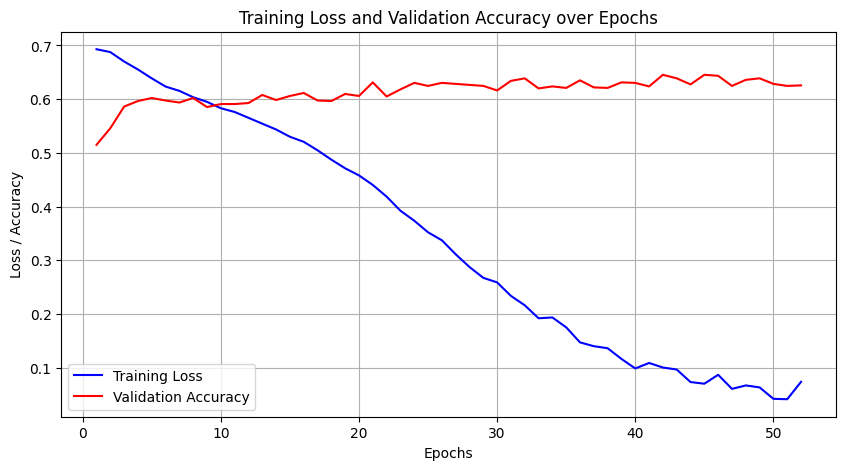

In [52]:
plot_loss_accuracy(losses, accuracies)

In [53]:
last_gru_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6792


### 4 layers

Trying with an increased number of stack layers

In [54]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # increased to 4 for stacking multiple layers
    pooling_method="last_state"
)

In [55]:
# training with mean max pooling over the biGRU outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state"
)

Epoch   1/100, Loss: 0.6934, Accuracy: 0.5356
Model saved.
Epoch   2/100, Loss: 0.6818, Accuracy: 0.5553
Model saved.
Epoch   3/100, Loss: 0.6674, Accuracy: 0.5666
Model saved.
Epoch   4/100, Loss: 0.6500, Accuracy: 0.5994
Model saved.
Epoch   5/100, Loss: 0.6345, Accuracy: 0.5929
Epoch   6/100, Loss: 0.6216, Accuracy: 0.5957
Epoch   7/100, Loss: 0.6072, Accuracy: 0.6023
Model saved.
Epoch   8/100, Loss: 0.5991, Accuracy: 0.5929
Epoch   9/100, Loss: 0.5894, Accuracy: 0.6013
Epoch  10/100, Loss: 0.5798, Accuracy: 0.5947
Epoch  11/100, Loss: 0.5659, Accuracy: 0.5947
Epoch  12/100, Loss: 0.5541, Accuracy: 0.6023
Epoch  13/100, Loss: 0.5407, Accuracy: 0.5863
Epoch  14/100, Loss: 0.5236, Accuracy: 0.6079
Model saved.
Epoch  15/100, Loss: 0.5135, Accuracy: 0.5938
Epoch  16/100, Loss: 0.4931, Accuracy: 0.6098
Model saved.
Epoch  17/100, Loss: 0.4804, Accuracy: 0.6154
Model saved.
Epoch  18/100, Loss: 0.4574, Accuracy: 0.6069
Epoch  19/100, Loss: 0.4346, Accuracy: 0.6135
Epoch  20/100, Loss: 0

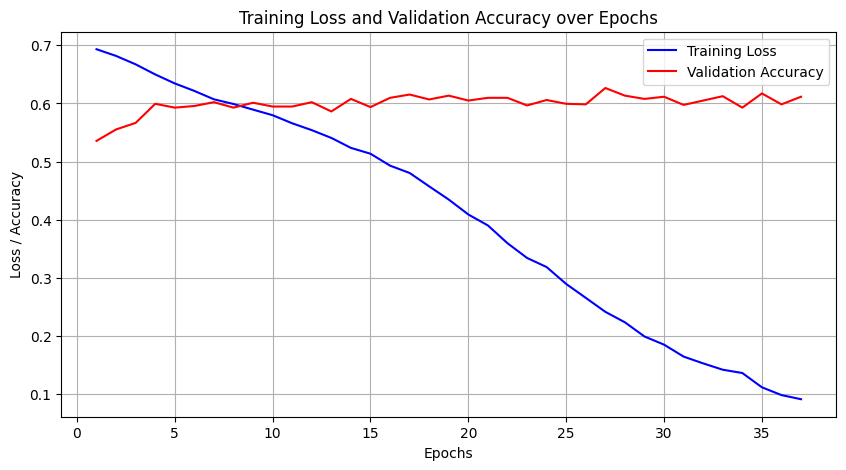

In [56]:
plot_loss_accuracy(losses, accuracies)

In [57]:
last_gru_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6482


## Mean Pool

### 2 layers

In [58]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="mean_pool"
)

In [59]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_pool"
)

Epoch   1/100, Loss: 0.6920, Accuracy: 0.5572
Model saved.
Epoch   2/100, Loss: 0.6793, Accuracy: 0.5788
Model saved.
Epoch   3/100, Loss: 0.6655, Accuracy: 0.5788
Epoch   4/100, Loss: 0.6483, Accuracy: 0.5994
Model saved.
Epoch   5/100, Loss: 0.6367, Accuracy: 0.5994
Epoch   6/100, Loss: 0.6253, Accuracy: 0.6051
Model saved.
Epoch   7/100, Loss: 0.6172, Accuracy: 0.6032
Epoch   8/100, Loss: 0.6071, Accuracy: 0.6032
Epoch   9/100, Loss: 0.6021, Accuracy: 0.5985
Epoch  10/100, Loss: 0.5923, Accuracy: 0.6032
Epoch  11/100, Loss: 0.5865, Accuracy: 0.6144
Model saved.
Epoch  12/100, Loss: 0.5795, Accuracy: 0.6098
Epoch  13/100, Loss: 0.5695, Accuracy: 0.6060
Epoch  14/100, Loss: 0.5592, Accuracy: 0.6210
Model saved.
Epoch  15/100, Loss: 0.5495, Accuracy: 0.6276
Model saved.
Epoch  16/100, Loss: 0.5361, Accuracy: 0.6370
Model saved.
Epoch  17/100, Loss: 0.5247, Accuracy: 0.6323
Epoch  18/100, Loss: 0.5054, Accuracy: 0.6248
Epoch  19/100, Loss: 0.4923, Accuracy: 0.6417
Model saved.
Epoch  20

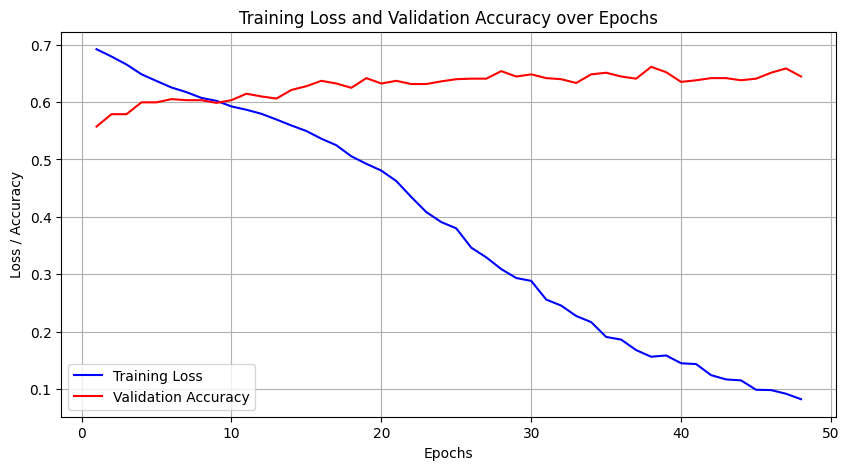

In [60]:
plot_loss_accuracy(losses, accuracies)

In [61]:
mean_gru_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6689


### 4 layers

Trying with an increased number of stack layers

In [62]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # increased to 4 for stacking multiple layers
    pooling_method="mean_pool"
)

In [63]:
# training with mean max pooling over the biGRU outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_pool"
)

Epoch   1/100, Loss: 0.6917, Accuracy: 0.5544
Model saved.
Epoch   2/100, Loss: 0.6806, Accuracy: 0.5844
Model saved.
Epoch   3/100, Loss: 0.6592, Accuracy: 0.5957
Model saved.
Epoch   4/100, Loss: 0.6454, Accuracy: 0.5938
Epoch   5/100, Loss: 0.6352, Accuracy: 0.5957
Epoch   6/100, Loss: 0.6254, Accuracy: 0.5826
Epoch   7/100, Loss: 0.6139, Accuracy: 0.6041
Model saved.
Epoch   8/100, Loss: 0.6056, Accuracy: 0.5919
Epoch   9/100, Loss: 0.5991, Accuracy: 0.5976
Epoch  10/100, Loss: 0.5917, Accuracy: 0.6069
Model saved.
Epoch  11/100, Loss: 0.5790, Accuracy: 0.6060
Epoch  12/100, Loss: 0.5690, Accuracy: 0.6220
Model saved.
Epoch  13/100, Loss: 0.5562, Accuracy: 0.6154
Epoch  14/100, Loss: 0.5411, Accuracy: 0.6229
Model saved.
Epoch  15/100, Loss: 0.5260, Accuracy: 0.6163
Epoch  16/100, Loss: 0.5086, Accuracy: 0.6285
Model saved.
Epoch  17/100, Loss: 0.5010, Accuracy: 0.6266
Epoch  18/100, Loss: 0.4771, Accuracy: 0.6069
Epoch  19/100, Loss: 0.4557, Accuracy: 0.6266
Epoch  20/100, Loss: 0

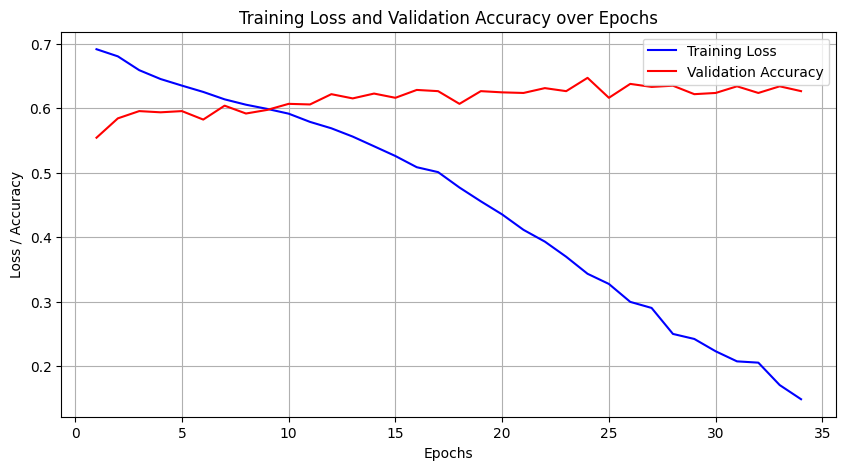

In [64]:
plot_loss_accuracy(losses, accuracies)

In [65]:
mean_gru_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6501


## Max Pool

### 2 layers

In [66]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="max_pool"
)

In [67]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool"
)

Epoch   1/100, Loss: 0.6908, Accuracy: 0.5441
Model saved.
Epoch   2/100, Loss: 0.6781, Accuracy: 0.5685
Model saved.
Epoch   3/100, Loss: 0.6626, Accuracy: 0.5882
Model saved.
Epoch   4/100, Loss: 0.6459, Accuracy: 0.6079
Model saved.
Epoch   5/100, Loss: 0.6322, Accuracy: 0.6098
Model saved.
Epoch   6/100, Loss: 0.6220, Accuracy: 0.6060
Epoch   7/100, Loss: 0.6099, Accuracy: 0.6135
Model saved.
Epoch   8/100, Loss: 0.6006, Accuracy: 0.6098
Epoch   9/100, Loss: 0.5866, Accuracy: 0.6323
Model saved.
Epoch  10/100, Loss: 0.5756, Accuracy: 0.6388
Model saved.
Epoch  11/100, Loss: 0.5589, Accuracy: 0.6229
Epoch  12/100, Loss: 0.5458, Accuracy: 0.6332
Epoch  13/100, Loss: 0.5350, Accuracy: 0.6585
Model saved.
Epoch  14/100, Loss: 0.5157, Accuracy: 0.6567
Epoch  15/100, Loss: 0.4962, Accuracy: 0.6445
Epoch  16/100, Loss: 0.4781, Accuracy: 0.6351
Epoch  17/100, Loss: 0.4594, Accuracy: 0.6435
Epoch  18/100, Loss: 0.4382, Accuracy: 0.6388
Epoch  19/100, Loss: 0.4225, Accuracy: 0.6332
Epoch  20

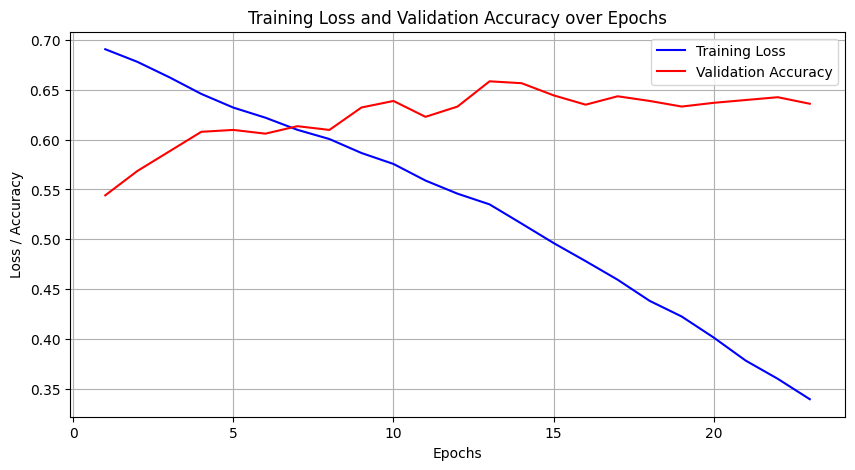

In [68]:
plot_loss_accuracy(losses, accuracies)

In [69]:
max_gru_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6642


### 4 layers

In [70]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # increased to 4 for stacking multiple layers
    pooling_method="max_pool"
)

In [71]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool"
)

Epoch   1/100, Loss: 0.6920, Accuracy: 0.5591
Model saved.
Epoch   2/100, Loss: 0.6754, Accuracy: 0.5750
Model saved.
Epoch   3/100, Loss: 0.6564, Accuracy: 0.6051
Model saved.
Epoch   4/100, Loss: 0.6380, Accuracy: 0.6032
Epoch   5/100, Loss: 0.6215, Accuracy: 0.6210
Model saved.
Epoch   6/100, Loss: 0.6048, Accuracy: 0.6144
Epoch   7/100, Loss: 0.5875, Accuracy: 0.6248
Model saved.
Epoch   8/100, Loss: 0.5658, Accuracy: 0.6107
Epoch   9/100, Loss: 0.5517, Accuracy: 0.6032
Epoch  10/100, Loss: 0.5340, Accuracy: 0.5929
Epoch  11/100, Loss: 0.5130, Accuracy: 0.5985
Epoch  12/100, Loss: 0.4909, Accuracy: 0.6229
Epoch  13/100, Loss: 0.4715, Accuracy: 0.5769
Epoch  14/100, Loss: 0.4530, Accuracy: 0.6004
Epoch  15/100, Loss: 0.4263, Accuracy: 0.6088
Epoch  16/100, Loss: 0.4037, Accuracy: 0.6229
Epoch  17/100, Loss: 0.3871, Accuracy: 0.6041
Early stopping triggered after 17 epochs.
Training ended, loading best model...
Model loaded.


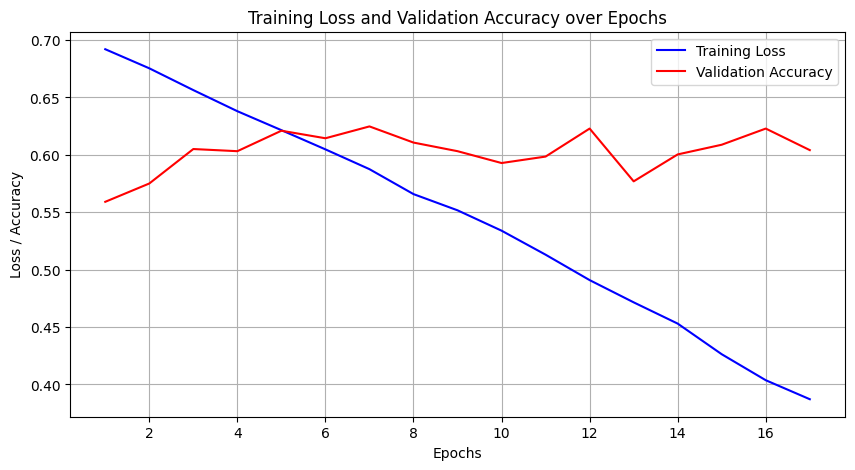

In [72]:
plot_loss_accuracy(losses, accuracies)

In [73]:
max_gru_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6351


## Mean Max Pool

### 2 layers

In [74]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="mean_max"
)

In [75]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6913, Accuracy: 0.5675
Model saved.
Epoch   2/100, Loss: 0.6760, Accuracy: 0.5826
Model saved.
Epoch   3/100, Loss: 0.6559, Accuracy: 0.6023
Model saved.
Epoch   4/100, Loss: 0.6441, Accuracy: 0.5797
Epoch   5/100, Loss: 0.6317, Accuracy: 0.6107
Model saved.
Epoch   6/100, Loss: 0.6223, Accuracy: 0.6023
Epoch   7/100, Loss: 0.6134, Accuracy: 0.6079
Epoch   8/100, Loss: 0.6051, Accuracy: 0.6041
Epoch   9/100, Loss: 0.5997, Accuracy: 0.6004
Epoch  10/100, Loss: 0.5885, Accuracy: 0.6116
Model saved.
Epoch  11/100, Loss: 0.5799, Accuracy: 0.6069
Epoch  12/100, Loss: 0.5743, Accuracy: 0.6154
Model saved.
Epoch  13/100, Loss: 0.5651, Accuracy: 0.6313
Model saved.
Epoch  14/100, Loss: 0.5566, Accuracy: 0.6201
Epoch  15/100, Loss: 0.5454, Accuracy: 0.6332
Model saved.
Epoch  16/100, Loss: 0.5370, Accuracy: 0.6229
Epoch  17/100, Loss: 0.5216, Accuracy: 0.6191
Epoch  18/100, Loss: 0.5039, Accuracy: 0.6079
Epoch  19/100, Loss: 0.4858, Accuracy: 0.6407
Model saved.
Epoch  20

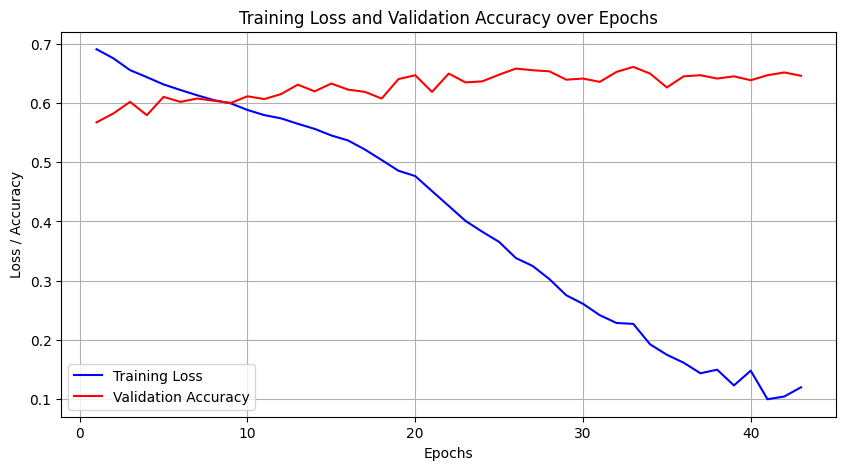

In [76]:
plot_loss_accuracy(losses, accuracies)

In [77]:
mean_max_gru_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6651


### 4 layers

In [78]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # increased to 4 for stacking multiple layers
    pooling_method="mean_max"
)

In [79]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6913, Accuracy: 0.5600
Model saved.
Epoch   2/100, Loss: 0.6788, Accuracy: 0.5675
Model saved.
Epoch   3/100, Loss: 0.6606, Accuracy: 0.5891
Model saved.
Epoch   4/100, Loss: 0.6450, Accuracy: 0.5976
Model saved.
Epoch   5/100, Loss: 0.6331, Accuracy: 0.5957
Epoch   6/100, Loss: 0.6201, Accuracy: 0.6154
Model saved.
Epoch   7/100, Loss: 0.6056, Accuracy: 0.6173
Model saved.
Epoch   8/100, Loss: 0.5936, Accuracy: 0.6313
Model saved.
Epoch   9/100, Loss: 0.5766, Accuracy: 0.6135
Epoch  10/100, Loss: 0.5625, Accuracy: 0.6266
Epoch  11/100, Loss: 0.5425, Accuracy: 0.6341
Model saved.
Epoch  12/100, Loss: 0.5268, Accuracy: 0.6182
Epoch  13/100, Loss: 0.5090, Accuracy: 0.6266
Epoch  14/100, Loss: 0.4900, Accuracy: 0.6257
Epoch  15/100, Loss: 0.4737, Accuracy: 0.6492
Model saved.
Epoch  16/100, Loss: 0.4422, Accuracy: 0.6107
Epoch  17/100, Loss: 0.4257, Accuracy: 0.6060
Epoch  18/100, Loss: 0.4073, Accuracy: 0.6266
Epoch  19/100, Loss: 0.3863, Accuracy: 0.6144
Epoch  20

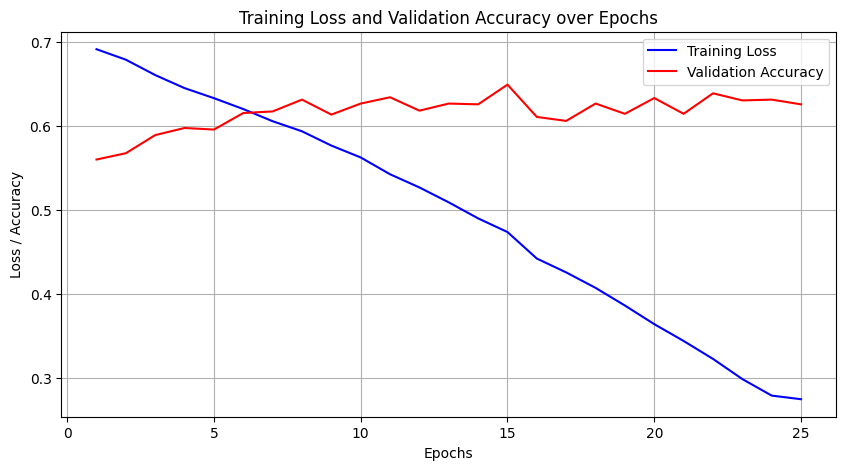

In [80]:
plot_loss_accuracy(losses, accuracies)

In [81]:
mean_max_gru_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6313


## Attention

### 2 layers

In [82]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2,              # set to 2 for stacking multiple layers
    pooling_method="attention"
)

In [83]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6916, Accuracy: 0.5535
Model saved.
Epoch   2/100, Loss: 0.6785, Accuracy: 0.5535
Epoch   3/100, Loss: 0.6600, Accuracy: 0.5947
Model saved.
Epoch   4/100, Loss: 0.6482, Accuracy: 0.5919
Epoch   5/100, Loss: 0.6363, Accuracy: 0.5976
Model saved.
Epoch   6/100, Loss: 0.6271, Accuracy: 0.6098
Model saved.
Epoch   7/100, Loss: 0.6171, Accuracy: 0.6013
Epoch   8/100, Loss: 0.6087, Accuracy: 0.6116
Model saved.
Epoch   9/100, Loss: 0.5998, Accuracy: 0.6135
Model saved.
Epoch  10/100, Loss: 0.5906, Accuracy: 0.6135
Epoch  11/100, Loss: 0.5833, Accuracy: 0.6238
Model saved.
Epoch  12/100, Loss: 0.5751, Accuracy: 0.6201
Epoch  13/100, Loss: 0.5620, Accuracy: 0.6144
Epoch  14/100, Loss: 0.5505, Accuracy: 0.6144
Epoch  15/100, Loss: 0.5366, Accuracy: 0.6313
Model saved.
Epoch  16/100, Loss: 0.5285, Accuracy: 0.6370
Model saved.
Epoch  17/100, Loss: 0.5050, Accuracy: 0.6304
Epoch  18/100, Loss: 0.5005, Accuracy: 0.6341
Epoch  19/100, Loss: 0.4695, Accuracy: 0.6304
Epoch  20

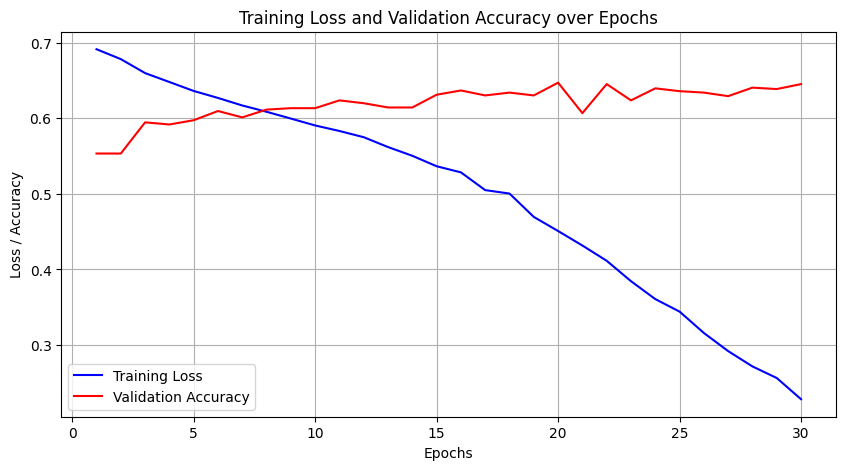

In [84]:
plot_loss_accuracy(losses, accuracies)

In [85]:
attention_gru_2_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6585


### 4 layers

In [86]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=4,              # increased to 4 for stacking multiple layers
    pooling_method="attention"
)

In [87]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6905, Accuracy: 0.5488
Model saved.
Epoch   2/100, Loss: 0.6736, Accuracy: 0.5854
Model saved.
Epoch   3/100, Loss: 0.6587, Accuracy: 0.6041
Model saved.
Epoch   4/100, Loss: 0.6450, Accuracy: 0.5854
Epoch   5/100, Loss: 0.6367, Accuracy: 0.5976
Epoch   6/100, Loss: 0.6227, Accuracy: 0.5985
Epoch   7/100, Loss: 0.6144, Accuracy: 0.6041
Epoch   8/100, Loss: 0.6019, Accuracy: 0.6069
Model saved.
Epoch   9/100, Loss: 0.5872, Accuracy: 0.6144
Model saved.
Epoch  10/100, Loss: 0.5725, Accuracy: 0.6191
Model saved.
Epoch  11/100, Loss: 0.5576, Accuracy: 0.6098
Epoch  12/100, Loss: 0.5365, Accuracy: 0.6173
Epoch  13/100, Loss: 0.5184, Accuracy: 0.6069
Epoch  14/100, Loss: 0.4973, Accuracy: 0.6032
Epoch  15/100, Loss: 0.4739, Accuracy: 0.6116
Epoch  16/100, Loss: 0.4558, Accuracy: 0.6266
Model saved.
Epoch  17/100, Loss: 0.4326, Accuracy: 0.6313
Model saved.
Epoch  18/100, Loss: 0.4068, Accuracy: 0.6341
Model saved.
Epoch  19/100, Loss: 0.3902, Accuracy: 0.6238
Epoch  20

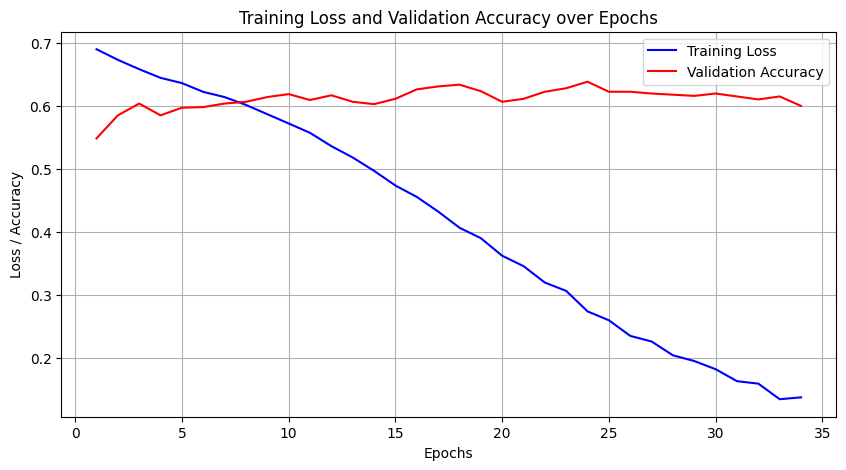

In [88]:
plot_loss_accuracy(losses, accuracies)

In [89]:
attention_gru_4_accuracy = validate(model, tst_dataloader)

Accuracy: 0.6398


# Results

In [91]:
print("Last state pooling:")
print(f"BiLSTM 2-layer: {last_lstm_2_accuracy:.4f}")
print(f"BiLSTM 4-layer: {last_lstm_4_accuracy:.4f}")
print(f"BiGRU 2-layer:  {last_gru_2_accuracy:.4f}")
print(f"BiGRU 4-layer:  {last_gru_4_accuracy:.4f}")
print("Mean pooling:")
print(f"BiLSTM 2-layer: {mean_lstm_2_accuracy:.4f}")
print(f"BiLSTM 4-layer: {mean_lstm_4_accuracy:.4f}")
print(f"BiGRU 2-layer:  {mean_gru_2_accuracy:.4f}")
print(f"BiGRU 4-layer:  {mean_gru_4_accuracy:.4f}")
print("Max pooling:")
print(f"BiLSTM 2-layer: {max_lstm_2_accuracy:.4f}")
print(f"BiLSTM 4-layer: {max_lstm_4_accuracy:.4f}")
print(f"BiGRU 2-layer:  {max_gru_2_accuracy:.4f}")
print(f"BiGRU 4-layer:  {max_gru_4_accuracy:.4f}")
print("Mean Max Pooling:")
print(f"BiLSTM 2-layer: {mean_max_lstm_2_accuracy:.4f}")
print(f"BiLSTM 4-layer: {mean_max_lstm_4_accuracy:.4f}")
print(f"BiGRU 2-layer:  {mean_max_gru_2_accuracy:.4f}")
print(f"BiGRU 4-layer:  {mean_max_gru_4_accuracy:.4f}")
print("Attention:")
print(f"BiLSTM 2-layer: {attention_lstm_2_accuracy:.4f}")
print(f"BiLSTM 4-layer: {attention_lstm_4_accuracy:.4f}")
print(f"BiGRU 2-layer:  {attention_gru_2_accuracy:.4f}")
print(f"BiGRU 4-layer:  {attention_gru_4_accuracy:.4f}")

Last state pooling:
BiLSTM 2-layer: 0.6595
BiLSTM 4-layer: 0.6538
BiGRU 2-layer:  0.6792
BiGRU 4-layer:  0.6482
Mean pooling:
BiLSTM 2-layer: 0.6426
BiLSTM 4-layer: 0.6689
BiGRU 2-layer:  0.6689
BiGRU 4-layer:  0.6501
Max pooling:
BiLSTM 2-layer: 0.6585
BiLSTM 4-layer: 0.6651
BiGRU 2-layer:  0.6642
BiGRU 4-layer:  0.6351
Mean Max Pooling:
BiLSTM 2-layer: 0.6707
BiLSTM 4-layer: 0.6632
BiGRU 2-layer:  0.6651
BiGRU 4-layer:  0.6313
Attention:
BiLSTM 2-layer: 0.6689
BiLSTM 4-layer: 0.6595
BiGRU 2-layer:  0.6585
BiGRU 4-layer:  0.6398
